<a href="https://colab.research.google.com/github/DrewHopkins/Hubble-Constant/blob/main/Hubble_Constant_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data from the Supernova Cosmology Probe (SCP) project at LBL:
# http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import make_regression 
from sklearn import metrics
from scipy import stats

# read in the table
data = files.upload()
data = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
# pull out the redshifts (zs), magnitudes (mm) and magnitude estimated errors (dm)
zs = data.T[1]
mm = data.T[2]
dm = data.T[3]
dlabel = 'SCP_2.1'

Saving SCPUnion2.1_mu_vs_z.txt to SCPUnion2.1_mu_vs_z (2).txt


In [ ]:
# mm is the "distance modulus" - http://en.wikipedia.org/wiki/Distance_modulus
# from which we can compute the distance in parsecs (pc)
dpc = 10.**(mm/5.+1.)
# and in megaparsecs (Mpc)
dMpc = dpc / 10.**6
# and the error on that distance:
dMe = 10.**((mm+dm)/5.+1.-6.) - dMpc

In [ ]:
# the Hubble relation :  d = c*z/H0 , with H0 in km/s/Mpc
c = 3.e5   # speed of light in km/s
# more accurately, the Hubble relation is d = c*z*sqrt(z)/H0
# so let's estimate H0 from the data; but only for small zs in linear region:
indx = np.where(zs < 0.05)
H0 = (c/dMpc[indx]*zs[indx]).mean()
#H0 = (c/dMpc*zs*np.sqrt(1+zs)).mean()
# make a string to print on the plot:
sH0 = 'H0 = '+str(round(H0))+' km/s/Mpc'


In [ ]:
# Draw curves to "predict" where the data points should lie.
# first, make a vector of redshifts with the numpy "arange" function.

dz = 0.001
zz = np.arange(dz,2.0,dz)
# the simplest (linear in z) Hubble relation curve:
ds1 = c/H0*zz
# a bit more accurate (and very similar to FRW with OmM = 0.43)
ds2 = c/H0*zz*np.sqrt(1.+zz)

# The general Hubble relation, Standard cosmological model, CDMLambda
OmM = 0.3  # fraction of matter, both ordinary matter (7%) and dark matter (23%)
OmL = 1. - OmM   # fraction of dark energy. They sum to 1 in our flat universe.

# This is the Friedmann-Robertson-Walker (FRW) integral for a flat universe:
ds3 = c/H0*np.cumsum(1./np.sqrt(OmM*(1+zz)**3+OmL))*dz*(1.+zz)

# in terms of magnitudes rather than distance:
m1 = (np.log10(ds1)+5.)*5. 
m2 = (np.log10(ds2)+5.)*5. 
m3 = (np.log10(ds3)+5.)*5. 


In [ ]:
# compute the match between the data and the predictions,
#  using the chisq-per-degree-of-freedom:
# get the predictions at the same redshifts as the data, by interpolating:
dp2 = np.interp(zs,zz,ds2)
dp3 = np.interp(zs,zz,ds3)

# compute the chisq per degree of freedom:
chisq2 = np.sum( ((dMpc-dp2)/dMe)**2 ) / dMpc.size
chisq3 = np.sum( ((dMpc-dp3)/dMe)**2 ) / dMpc.size
print('chisq2, chisq3 = ',chisq2,chisq3)


chisq2, chisq3 =  0.9805546495975834 0.9620136723761287


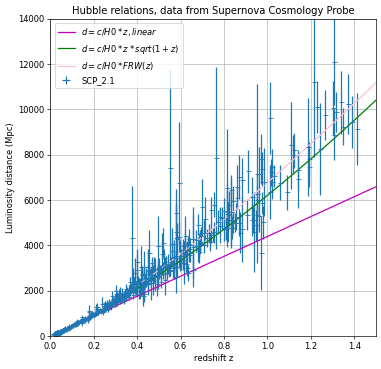

In [ ]:
# draw a linear-linear plot with all the data and the three Hubble relation curves:
plt.figure(1, figsize=(7, 7), frameon=False, dpi=60)
plt.errorbar(zs,dMpc,xerr=dz,yerr=dMe,fmt='+',label=dlabel)

plt.plot(zz,ds1,'m',label="$d = c/H0*z, linear$")
plt.plot(zz,ds2,'g',label="$d = c/H0*z*sqrt(1+z)$")
plt.plot(zz,ds3,'pink',label="$d = c/H0*FRW(z)$")
plt.xlim([0,1.5])
plt.ylim([0,14000])
plt.xlabel('redshift z')
plt.ylabel('Luminosity distance (Mpc)')
#plt.text(0.1,9000,sH0,fontsize = 12)
plt.grid(b=True,which='both')
plt.legend(loc='upper left')
plt.title('Hubble relations, data from Supernova Cosmology Probe')
plt.show()



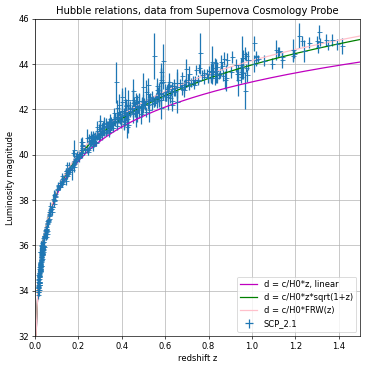

In [ ]:
# plot in terms of magnitudes (log scale) rather than distance:
plt.figure(1, figsize=(7, 7), frameon=False, dpi=60)
plt.errorbar(zs,mm,xerr=dz,yerr=dm,fmt='+',label=dlabel)
plt.plot(zz,m1,'m',label="d = c/H0*z, linear")
plt.plot(zz,m2,'g',label="d = c/H0*z*sqrt(1+z)")
plt.plot(zz,m3,'pink',label="d = c/H0*FRW(z)")
plt.xlim([0.,1.5])
plt.ylim([32,46])
plt.xlabel('redshift z')
plt.ylabel('Luminosity magnitude')
#plt.text(0.1,9000,sH0,fontsize = 12)
plt.grid(b=True,which='both')
plt.legend(loc='lower right')
plt.title('Hubble relations, data from Supernova Cosmology Probe')
plt.show()


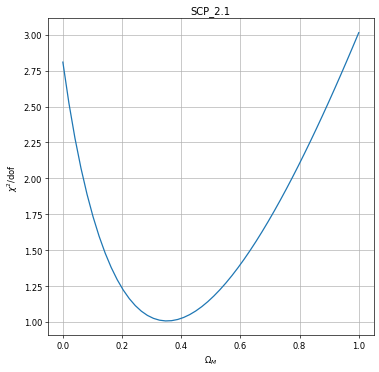

In [ ]:
# here we crudely estimate the best-fit value of OmM,
# assuming OmL = 1-OmM, and OmK = 0 (flat universe).
OmMs = np.linspace(0.,1.,50)
ch = np.zeros(OmMs.size)
for I in np.arange(OmMs.size):
    OmM = OmMs[I]
    OmL = 1.-OmM
    ds = c/H0*np.cumsum(1./np.sqrt(OmM*(1+zz)**3+OmL))*dz*(1.+zz)
    ms = (np.log10(ds)+5.)*5.
    mp = np.interp(zs,zz,ms)
    ch[I] = np.sum( ((mm-mp)/dm)**2 ) / mm.size

plt.figure(1, figsize=(7, 7), frameon=False, dpi=60)
plt.plot(OmMs,ch)
# we can use LaTeX to get greek letters:
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\chi^2$/dof')
plt.title(dlabel)
plt.grid()

plt.show()

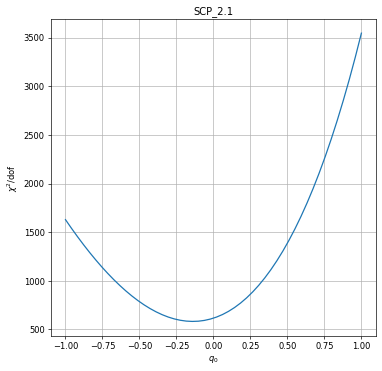

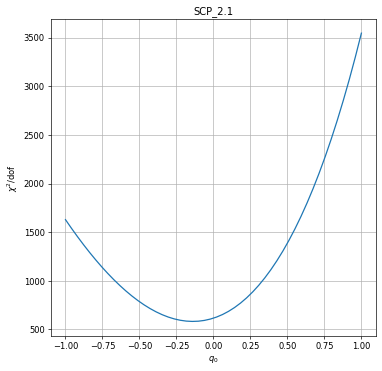

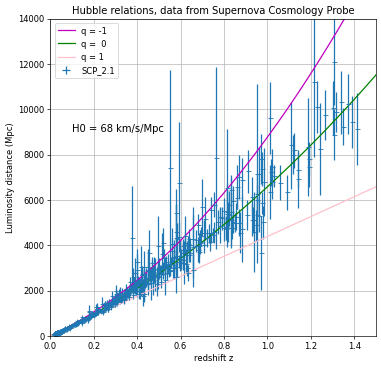

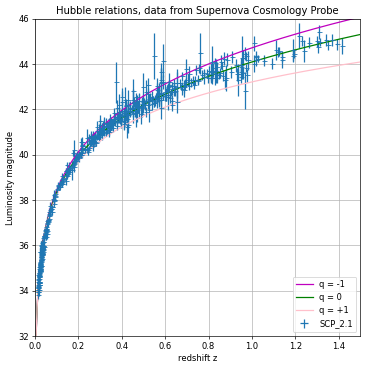

In [ ]:
# Now in terms of a deceleration parameter q0 (flat universe).
# q0 = +1 for a constant linear Hubble Law.
# q0 = 1/2 for a matter universe. q0 < 0 means acceleration.
qs = np.linspace(-1.,1.,50)
ch = np.zeros(qs.size)
for I in np.arange(qs.size):
    q = qs[I]
    #ds = c/H0*(zz+(1-q)/2.*zz**2)
    ds = c/H0*(zs+(1-q)/2.*zs**2)
    ms = (np.log10(ds)+5.)*5.
    #mp = np.interp(zs,zz,ms)
    ch[I] = np.sum( ((mm-ms)/dm)**2 )

plt.figure(1, figsize=(7, 7), frameon=False, dpi=60)
plt.plot(qs,ch)
# we can use LaTeX to get greek letters:
plt.xlabel(r'$q_0$')
plt.ylabel(r'$\chi^2$/dof')
plt.title(dlabel)
plt.grid()
plt.show()

plt.figure(1, figsize=(7, 7), frameon=False, dpi=60)
plt.plot(qs,ch)
# we can use LaTeX to get greek letters:
plt.xlabel(r'$q_0$')
plt.ylabel(r'$\chi^2$/dof')
plt.title(dlabel)
plt.grid()
plt.show()

# three extreme models
q1 = -1.
ds1 = c/H0*(zz+(1-q1)/2.*zz**2)
m1 = (np.log10(ds1)+5.)*5.
q2 =  0.
ds2 = c/H0*(zz+(1-q2)/2.*zz**2)
m2 = (np.log10(ds2)+5.)*5.
q3 =  1.
ds3 = c/H0*(zz+(1-q3)/2.*zz**2)
m3 = (np.log10(ds3)+5.)*5.

# plot d-v-z
plt.figure(1, figsize=(7, 7), frameon=False, dpi=60)
plt.errorbar(zs,dMpc,xerr=dz,yerr=dMe,fmt='+',label=dlabel)
plt.plot(zz,ds1,'m',label="q = -1")
plt.plot(zz,ds2,'g',label="q =  0")
plt.plot(zz,ds3,'pink',label="q = 1")
plt.xlim([0,1.5])
plt.ylim([0,14000])
plt.xlabel('redshift z')
plt.ylabel('Luminosity distance (Mpc)')
plt.text(0.1,9000,sH0,fontsize = 12)
plt.grid(b=True,which='both')
plt.legend(loc='upper left')
plt.title('Hubble relations, data from Supernova Cosmology Probe')
plt.show()

# plot m-v-z
plt.figure(1, figsize=(7, 7), frameon=False, dpi=60)
plt.errorbar(zs,mm,xerr=dz,yerr=dm,fmt='+',label=dlabel)
plt.plot(zz,m1,'m',label="q = -1")
plt.plot(zz,m2,'g',label="q = 0")
plt.plot(zz,m3,'pink',label="q = +1")
plt.xlim([0.,1.5])
plt.ylim([32,46])
plt.xlabel('redshift z')
plt.ylabel('Luminosity magnitude')
#plt.text(0.1,9000,sH0,fontsize = 12)
plt.grid(b=True,which='both')
plt.legend(loc='lower right')
plt.title('Hubble relations, data from Supernova Cosmology Probe')
plt.show()

# now via linear regression:
A = np.mat([[np.sum(zs**2/dMe**2),np.sum(zs**3/dMe**2)], \
            [np.sum(zs**3/dMe**2),np.sum(zs**4/dMe**2)]])
B = np.array([np.sum(zs*dMpc/dMe**2),np.sum(zs**2*dMpc/dMe**2)])
R = np.linalg.solve(A,B)
# disentangle the physical parameters
H0f = c/R[0]
qf = 1.-2.*R[1]/R[0]
# and the errors (correlated)
eH0f = H0f*np.sqrt(A.I[0,0])/R[0]
# get the error on q!


In [ ]:
##As redshift increases the luminosity distance increases at an increasing rate. Thus as a star is moving faster away then the further away from us it must be. This time we obtained a value of 68 for the hubble constant#